# Semantic Segmentation HomeWork

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import random

Download the pet dataset

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

# **U_NET:**

# Preprocessing data


In [3]:
NUM_EPOCHS = 30
image_size = 128

In [4]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (image_size, image_size), method="nearest")
   input_mask = tf.image.resize(input_mask, (image_size, image_size), method="nearest")
   return input_image, input_mask

In [5]:
# https://stackoverflow.com/questions/65475057/keras-data-augmentation-pipeline-for-image-segmentation-dataset-image-and-mask
def augment(input_image, input_mask):
  # your code here #
  # write suitable Augmentation transforms

  input_image = tf.cast(input_image, tf.float32)
  input_mask = tf.cast(input_mask, tf.float32)
  # zoom in a bit
  if tf.random.uniform(()) > 0.5:
      # use original image to preserve high resolution
      input_image = tf.image.central_crop(input_image, 0.75)
      input_mask = tf.image.central_crop(input_mask, 0.75)
      # resize
      input_image = tf.image.resize(input_image, (image_size, image_size))
      input_mask = tf.image.resize(input_mask, (image_size, image_size))
  
  # random brightness adjustment illumination
  input_image = tf.image.random_brightness(input_image, 0.3)
  # random contrast adjustment
  input_image = tf.image.random_contrast(input_image, 0.2, 0.5)
  
  # flipping random horizontal or vertical
  if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
  if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_up_down(input_image)
      input_mask = tf.image.flip_up_down(input_mask)

  # rotation in 90°s
  k = random.randint(1, 3)
  input_image = tf.image.rot90(input_image,k)
  input_mask = tf.image.rot90(input_mask,k)

  return input_image, input_mask

In [6]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [7]:
def load_image_train(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_train_aug(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask

In [9]:
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [10]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_aug = dataset["train"].map(load_image_train_aug, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
VALIDATION_SIZE = 3000
TEST_SIZE = 669

train_batches_aug = train_dataset_aug.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches_aug = train_batches_aug.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_batches = test_dataset.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_batches = test_dataset.skip(VALIDATION_SIZE).take(TEST_SIZE).batch(BATCH_SIZE)


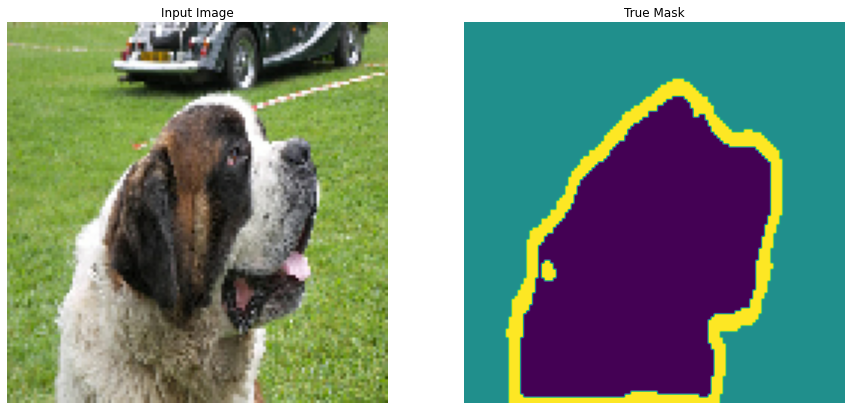

In [12]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

# UNet Architecture
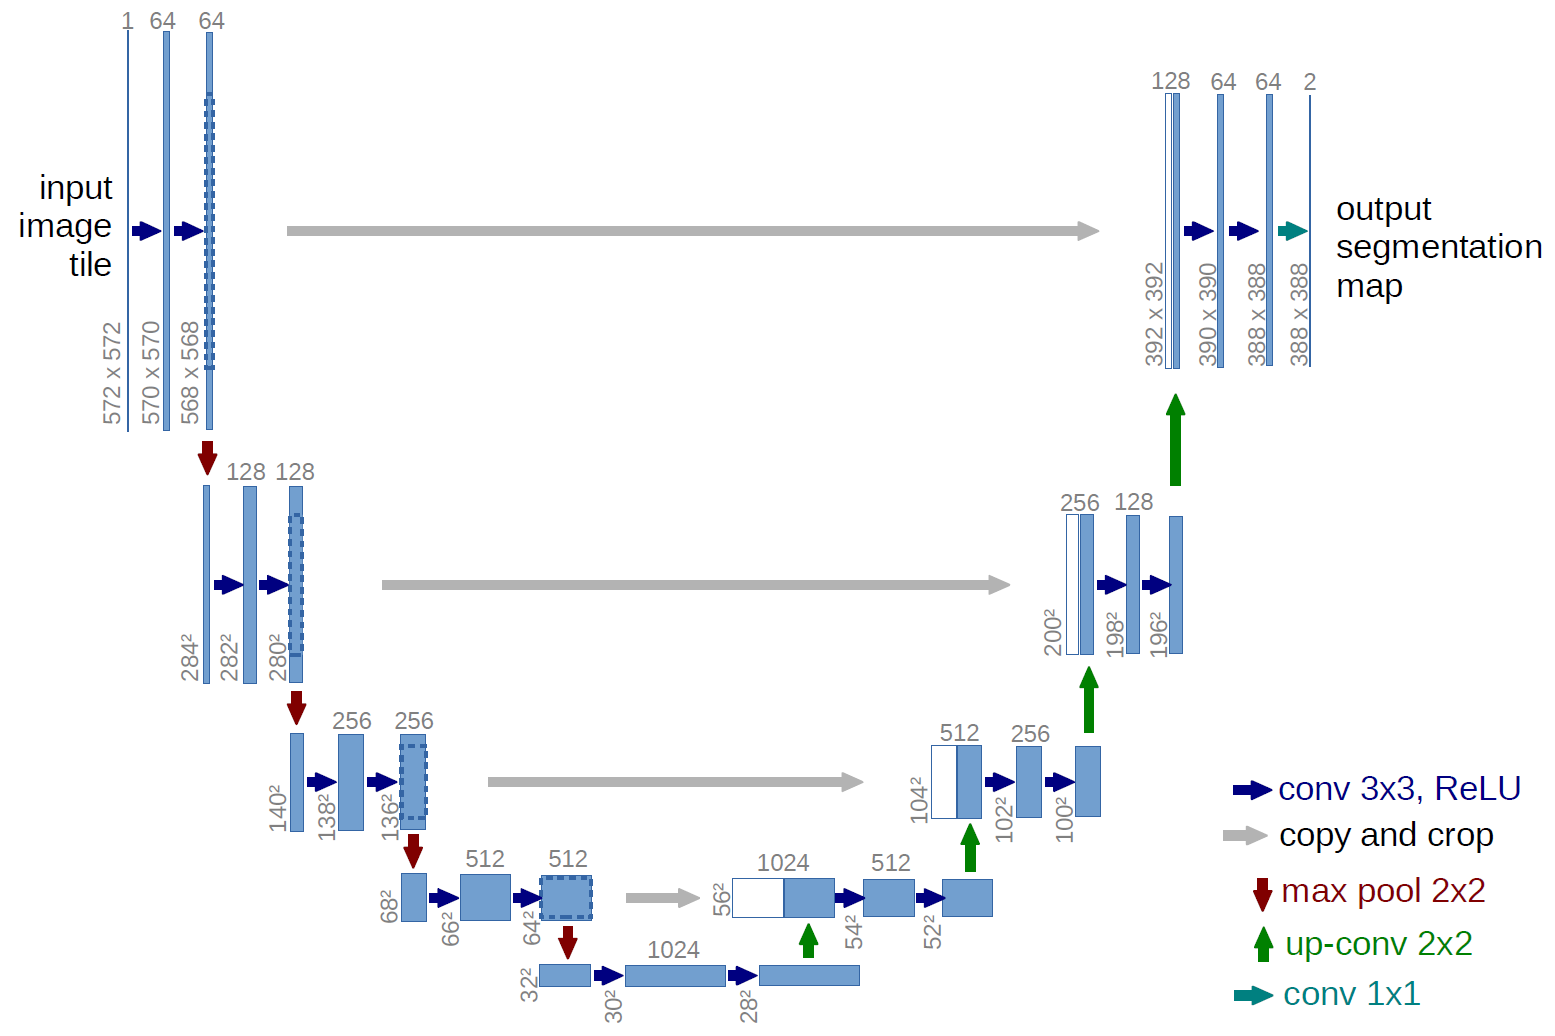



You can use the following link to get acquainted with convolution2d_transpose:


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/

In this part:

1.   Design UNet Encoder-Decoder model layer by layer with Keras tool
2.   Compile your model
3.   Train model, show and plot accuracy and loss
4.   display some of predicted masks beside related true masks

Notes:

Use Adam optimizer with learning rate 0.001 and sparse_categorical_crossentropy as loss function

Set accuracy for metrics


In [13]:
# https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/unet.py
# https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/resnet50_unet.py

""" Pre-trained ResNet50 Model """
from tensorflow.keras.applications import ResNet50

""" Input """
input_shape = (128, 128, 3)

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes, pre_trained):
    inputs = Input(input_shape)
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    if pre_trained:
      """ Encoder """
      s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
      s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
      s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
      s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

      """ Bridge """
      b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    else:
      s1, p1 = encoder_block(inputs, 64)
      s2, p2 = encoder_block(p1, 128)
      s3, p3 = encoder_block(p2, 256)
      s4, p4 = encoder_block(p3, 512)

      """ Bridge """
      b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    if pre_trained:
      model = Model(inputs, outputs, name="Pretrained")
    else:
      model = Model(inputs, outputs, name="U-Net")  
    return model

In [14]:
""" Hyperparameters """
shape = (image_size, image_size, 3)
num_classes = 37
lr = 1e-4

train_steps = len(train_dataset)//BATCH_SIZE
valid_steps = VALIDATION_SIZE//BATCH_SIZE

callbacks = [
        ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]
    
""" Model """
model = build_unet(shape, num_classes, pre_trained=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

history = model.fit(train_batches,
      steps_per_epoch=train_steps,
      validation_data=validation_batches,
      validation_steps=valid_steps,
      epochs=NUM_EPOCHS,
      callbacks=callbacks
  )


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


KeyboardInterrupt: ignored

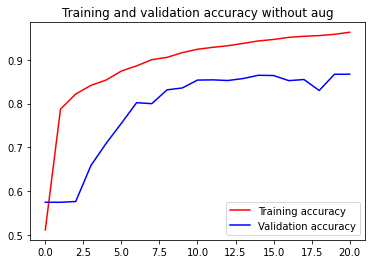

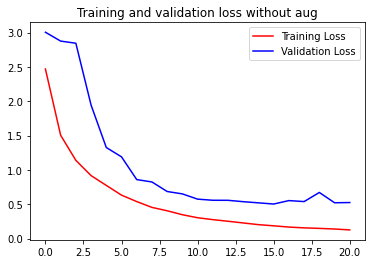

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy without aug')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss without aug')
plt.legend()

plt.show()

# With Augmentation

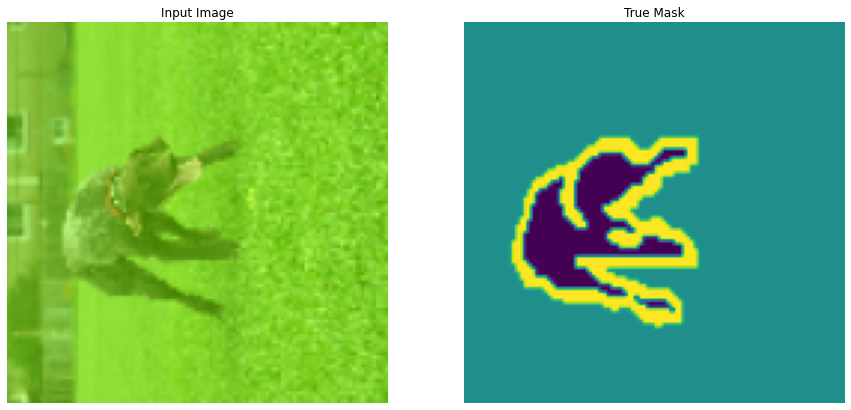

In [15]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches_aug))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [16]:
""" Hyperparameters """
shape = (image_size, image_size, 3)
num_classes = 37
lr = 1e-4

train_steps = len(train_dataset_aug)//BATCH_SIZE
valid_steps = VALIDATION_SIZE//BATCH_SIZE

callbacks = [
        ModelCheckpoint("model_aug.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]


""" Model """
model_aug = build_unet(shape, num_classes, pre_trained=False)
model_aug.compile(optimizer=tf.keras.optimizers.Adam(lr),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

history_aug = model_aug.fit(train_batches_aug,
      steps_per_epoch=train_steps,
      validation_data=validation_batches,
      validation_steps=valid_steps,
      epochs=NUM_EPOCHS,
      callbacks=callbacks
  )

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 2.8239 - accuracy: 0.4538
Epoch 1: saving model to model_aug.h5
57/57 [==============================] - 77s 1s/step - loss: 2.8239 - accuracy: 0.4538 - val_loss: 3.5029 - val_accuracy: 0.4820 - lr: 1.0000e-04
Epoch 2/30
57/57 [==============================] - ETA: 0s - loss: 1.9793 - accuracy: 0.6818
Epoch 2: saving model to model_aug.h5
57/57 [==============================] - 78s 1s/step - loss: 1.9793 - accuracy: 0.6818 - val_loss: 3.2746 - val_accuracy: 0.4370 - lr: 1.0000e-04
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 1.5563 - accuracy: 0.7145
Epoch 3: saving model to model_aug.h5
57/57 [==============================] - 70s 1s/step - loss: 1.5563 - accuracy: 0.7145 - val_loss: 2.5926 - val_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 4/30
57/57 [==============================] - ETA: 0s - loss: 1.2930 - accuracy: 0.7389
Epoch 4: saving model to model_aug.h5
57/57 [===========================

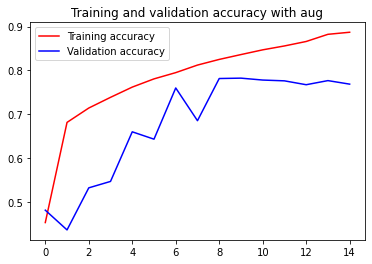

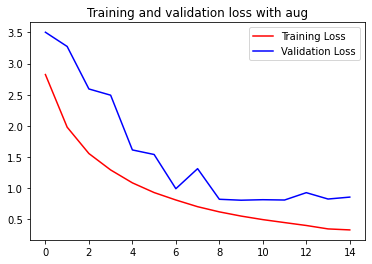

In [17]:
acc_aug = history_aug.history['accuracy']
val_acc_aug = history_aug.history['val_accuracy']
loss_aug = history_aug.history['loss']
val_loss_aug = history_aug.history['val_loss']

epochs = range(len(acc_aug))

plt.plot(epochs, acc_aug, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_aug, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy with aug')
plt.legend()

plt.figure()

plt.plot(epochs, loss_aug, 'r', label='Training Loss')
plt.plot(epochs, val_loss_aug, 'b', label='Validation Loss')
plt.title('Training and validation loss with aug')
plt.legend()

plt.show()

# Pretrained

In [14]:
""" Hyperparameters """
shape = (image_size, image_size, 3)
num_classes = 37
lr = 1e-4

train_steps = len(train_dataset_aug)//BATCH_SIZE
valid_steps = VALIDATION_SIZE//BATCH_SIZE

callbacks = [
        ModelCheckpoint("model_aug_pretrained.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]

""" Model """
model_aug_pretrained = build_unet(shape, num_classes, pre_trained=True)
model_aug_pretrained.compile(optimizer=tf.keras.optimizers.Adam(lr),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

history_aug_pretrained = model_aug_pretrained.fit(train_batches_aug,
      steps_per_epoch=train_steps,
      validation_data=validation_batches,
      validation_steps=valid_steps,
      epochs=NUM_EPOCHS,
      callbacks=callbacks
  )


Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - ETA: 0s - loss: 2.2570 - accuracy: 0.6102
Epoch 1: saving model to model_aug_pretrained.h5
57/57 [==============================] - 86s 1s/step - loss: 2.2570 - accuracy: 0.6102 - val_loss: 3.2611 - val_accuracy: 0.5697 - lr: 1.0000e-04
Epoch 2/30
57/57 [==============================] - ETA: 0s - loss: 1.2451 - accuracy: 0.8525
Epoch 2: saving model to model_aug_pretrained.h5
57/57 [==============================] - 66s 1s/step - loss: 1.2451 - accuracy: 0.8525 - val_loss: 2.8785 - val_accuracy: 0.5758 - lr: 1.0000e-04
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 0.9410 - accuracy: 0.8787
Epoch 3: saving model to model_aug_pretrained.h5
57/57 [==============================] - 59s 1s/step - loss: 0.9410 - accuracy: 0.8787 - val_loss: 2.6223 - val_accuracy: 0.5782 - lr: 1.0000e-04
Epoch 4/30
57/57 [==============================] - ETA: 0s - loss: 0.7689 - accuracy: 0.8890
Epoch 4: saving model to model_aug_pretrained.h5
5

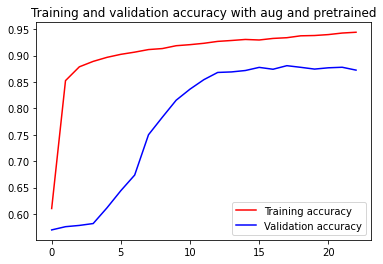

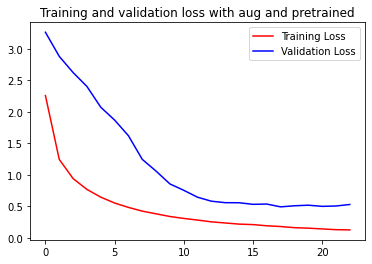

In [15]:
acc_aug_pretrained = history_aug_pretrained.history['accuracy']
val_acc_aug_pretrained = history_aug_pretrained.history['val_accuracy']
loss_aug_pretrained = history_aug_pretrained.history['loss']
val_loss_aug_pretrained = history_aug_pretrained.history['val_loss']

epochs = range(len(acc_aug_pretrained))

plt.plot(epochs, acc_aug_pretrained, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_aug_pretrained, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy with aug and pretrained')
plt.legend()

plt.figure()

plt.plot(epochs, loss_aug_pretrained, 'r', label='Training Loss')
plt.plot(epochs, val_loss_aug_pretrained, 'b', label='Validation Loss')
plt.title('Training and validation loss with aug and pretrained')
plt.legend()

plt.show()

11/11 [==============================] - 14s 349ms/step
47


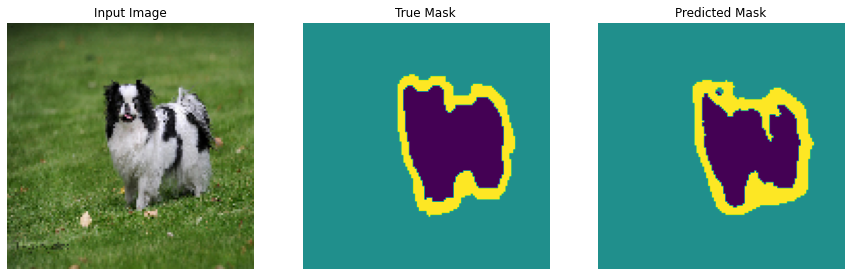

11/11 [==============================] - 13s 366ms/step - loss: 0.5252 - accuracy: 0.8741


[0.5252105593681335, 0.8741411566734314]

In [18]:
predictor = load_model('model_aug_pretrained.h5')
predicts = predictor.predict(test_batches)

def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
print(random_index)
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask, np.expand_dims(np.argmax(predicts[random_index], axis=-1), axis=-1)])

predictor.evaluate(test_batches)